# Predicting Problematic Internet Use in Children and Adolescents

## Introduction

In today’s digital age, excessive internet use among children and adolescents has become a growing concern. The prolonged use of technology is often linked to issues such as anxiety, depression, and reduced physical activity. However, current methods for identifying problematic internet use require professional assessments, making them inaccessible for many families due to cultural, linguistic, and socioeconomic barriers.

The goal of this project is to develop a predictive model that uses easily accessible physical activity and fitness data to detect early signs of problematic internet use. Specifically, we aim to predict the Severity Impairment Index (sii), a standard measure of problematic internet use, using a wide range of physical and behavioral features from the Healthy Brain Network (HBN) dataset.

By identifying patterns in children's physical activity and fitness habits, we hope to provide an alternative method for detecting problematic internet use, enabling earlier interventions and promoting healthier digital habits. Our model can serve as a proxy in environments lacking clinical expertise or specialized tools, helping families and caregivers take timely action to support healthier lifestyles for children and adolescents.

This project is not only about building a model—it's about contributing to a healthier, happier future where children are better equipped to manage their digital habits responsibly.

# Exploratory Data Analysis (EDA)

In this section, we explore the data to gain insights, clean and prepare it for modeling, and identify underlying patterns that may correlate with problematic internet use.

## Importing Libraries and Setting Up Environment

In [242]:
# Import necessary libraries
import warnings
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data
import lightgbm as lgb
import optuna

from sklearn.impute import KNNImputer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import early_stopping, log_evaluation

# Suppress warnings
warnings.filterwarnings("ignore", message="Failed to optimize method")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Can be set to run on small data subset to validate code works
IS_TEST = False

# Loading the Data

In [243]:
# Define data directory
DATA_DIR = Path("data")

# Load train and test datasets
train = pl.read_csv(DATA_DIR / "train.csv")
test = pl.read_csv(DATA_DIR / "test.csv")

# Understanding the Data Structure

The datasets contain various measurements from multiple instruments, including demographics, physical measures, fitness assessments, and questionnaires. The target variable is the Severity Impairment Index (sii), which is derived from the Parent-Child Internet Addiction Test (PCIAT).

## Checking for Missing Values

In [244]:
# Check for missing values in the training data
missing_values = train.select([pl.col(c).is_null().sum().alias(f"null_count_{c}") for c in train.columns])

# Use unpivot without the 'columns' keyword
# The first argument is the columns to unpivot, and the second argument is their values
missing_values_unpivoted = missing_values.unpivot(missing_values.columns).sort('value', descending=True)

# Display the missing values sorted by count
print(missing_values_unpivoted)

shape: (82, 2)
┌─────────────────────────────────┬───────┐
│ variable                        ┆ value │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ null_count_PAQ_A-Season         ┆ 3485  │
│ null_count_PAQ_A-PAQ_A_Total    ┆ 3485  │
│ null_count_Fitness_Endurance-T… ┆ 3220  │
│ null_count_Fitness_Endurance-T… ┆ 3220  │
│ null_count_Fitness_Endurance-M… ┆ 3217  │
│ …                               ┆ …     │
│ null_count_PreInt_EduHx-Season  ┆ 420   │
│ null_count_id                   ┆ 0     │
│ null_count_Basic_Demos-Enroll_… ┆ 0     │
│ null_count_Basic_Demos-Age      ┆ 0     │
│ null_count_Basic_Demos-Sex      ┆ 0     │
└─────────────────────────────────┴───────┘


We observe that many features have missing values, which need to be addressed during data preprocessing.

# Describing the Factors (Features)

In [245]:
# List of target columns
TARGET_COLS = [
    "PCIAT-PCIAT_01", "PCIAT-PCIAT_02", "PCIAT-PCIAT_03", "PCIAT-PCIAT_04", "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06", "PCIAT-PCIAT_07", "PCIAT-PCIAT_08", "PCIAT-PCIAT_09", "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11", "PCIAT-PCIAT_12", "PCIAT-PCIAT_13", "PCIAT-PCIAT_14", "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16", "PCIAT-PCIAT_17", "PCIAT-PCIAT_18", "PCIAT-PCIAT_19", "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total", "sii",
]

# List of feature columns
FEATURE_COLS = [
    "Basic_Demos-Enroll_Season", "Basic_Demos-Age", "Basic_Demos-Sex", "CGAS-Season",
    "CGAS-CGAS_Score", "Physical-Season", "Physical-BMI", "Physical-Height", "Physical-Weight",
    "Physical-Waist_Circumference", "Physical-Diastolic_BP", "Physical-HeartRate",
    "Physical-Systolic_BP", "Fitness_Endurance-Season", "Fitness_Endurance-Max_Stage",
    "Fitness_Endurance-Time_Mins", "Fitness_Endurance-Time_Sec", "FGC-Season", "FGC-FGC_CU",
    "FGC-FGC_CU_Zone", "FGC-FGC_GSND", "FGC-FGC_GSND_Zone", "FGC-FGC_GSD", "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU", "FGC-FGC_PU_Zone", "FGC-FGC_SRL", "FGC-FGC_SRL_Zone", "FGC-FGC_SRR",
    "FGC-FGC_SRR_Zone", "FGC-FGC_TL", "FGC-FGC_TL_Zone", "BIA-Season", "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC", "BIA-BIA_BMI", "BIA-BIA_BMR", "BIA-BIA_DEE", "BIA-BIA_ECW", "BIA-BIA_FFM",
    "BIA-BIA_FFMI", "BIA-BIA_FMI", "BIA-BIA_Fat", "BIA-BIA_Frame_num", "BIA-BIA_ICW", "BIA-BIA_LDM",
    "BIA-BIA_LST", "BIA-BIA_SMM", "BIA-BIA_TBW", "PAQ_A-Season", "PAQ_A-PAQ_A_Total",
    "PAQ_C-Season", "PAQ_C-PAQ_C_Total", "SDS-Season", "SDS-SDS_Total_Raw", "SDS-SDS_Total_T",
    "PreInt_EduHx-Season", "PreInt_EduHx-computerinternet_hoursday",
]

These features encompass demographic information, physical measures, fitness assessments, bio-electric impedance analysis, physical activity questionnaires, sleep disturbance scales, and internet usage.

# Visualizing Target Variable Distribution

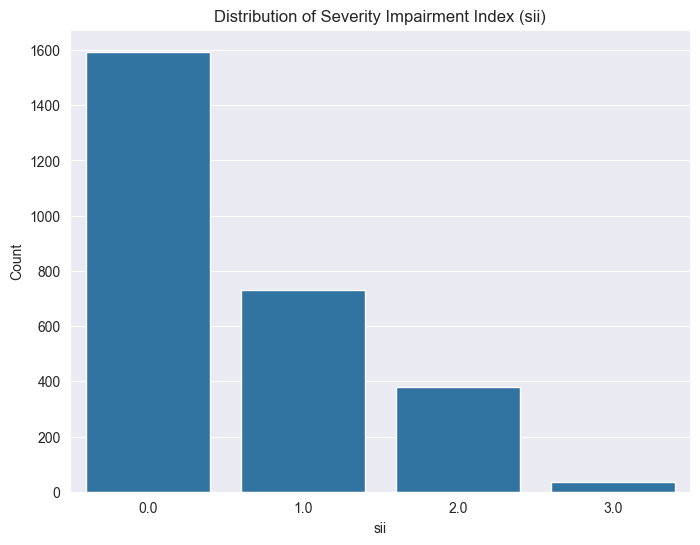

In [246]:
# Convert to pandas for visualization
train_pd = train.select(TARGET_COLS).to_pandas()

# Plot the distribution of 'sii'
plt.figure(figsize=(8, 6))
sns.countplot(x='sii', data=train_pd)
plt.title('Distribution of Severity Impairment Index (sii)')
plt.xlabel('sii')
plt.ylabel('Count')
plt.show()

We observe that the target variable 'sii' is imbalanced, with most participants having lower severity levels.

# Correlation Analysis

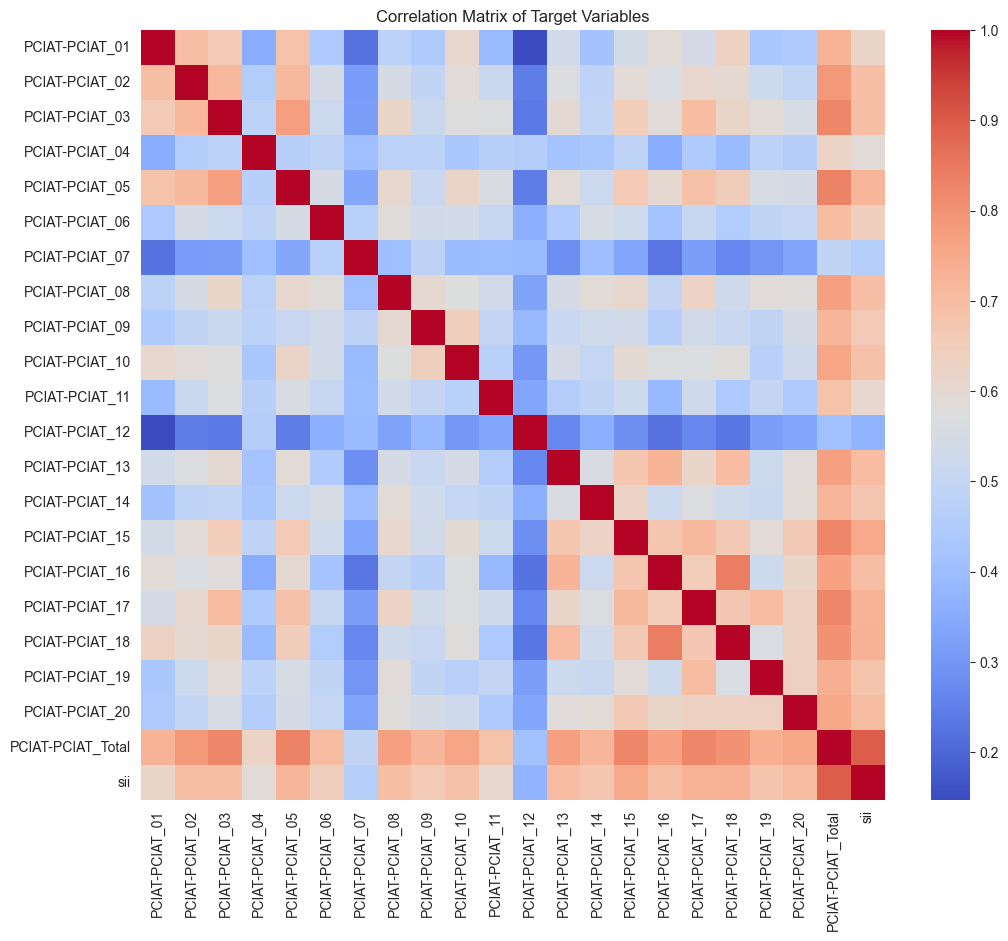

In [247]:
# Compute correlation matrix
corr_matrix = train_pd.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Target Variables')
plt.show()

# Data Distribution

Understanding the features and how they are distributed.

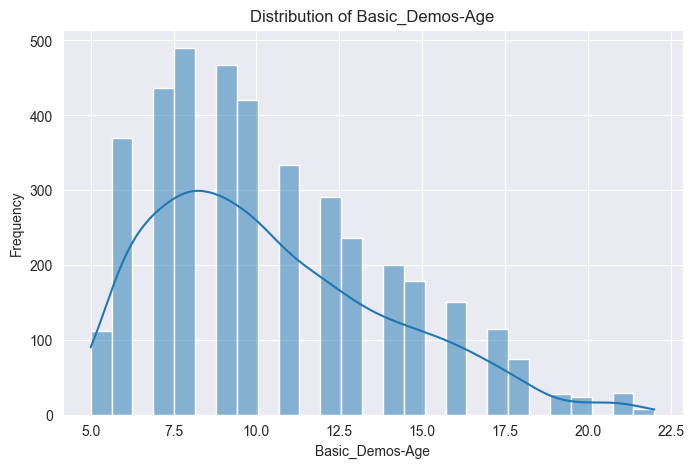

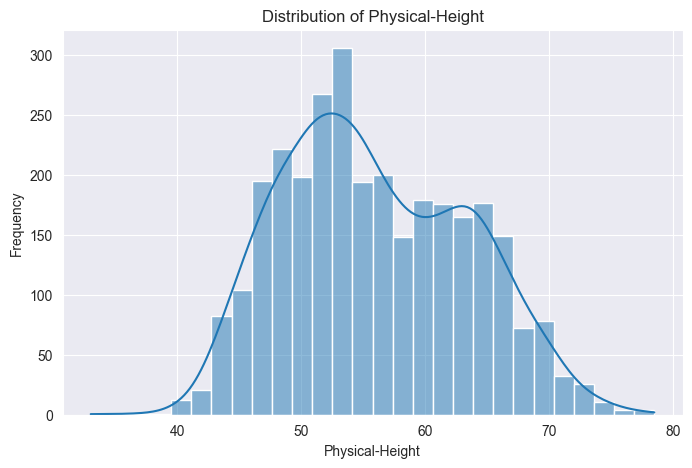

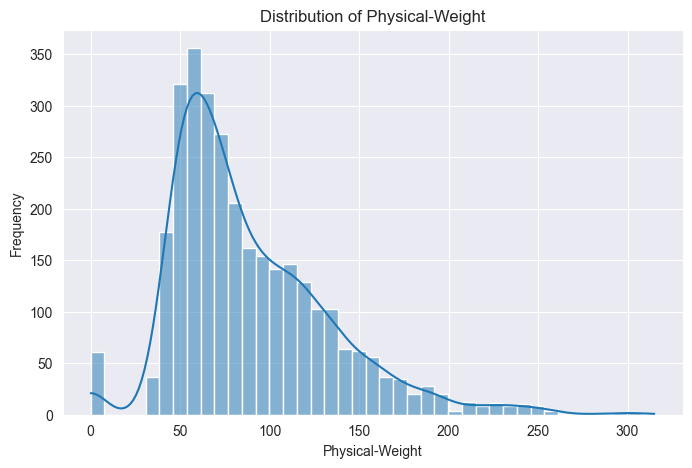

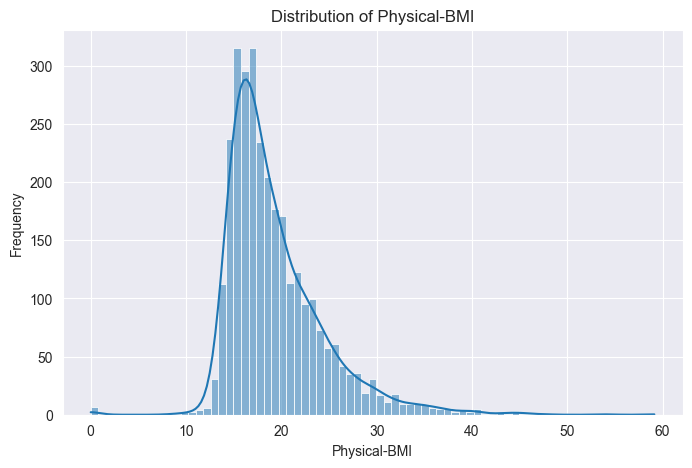

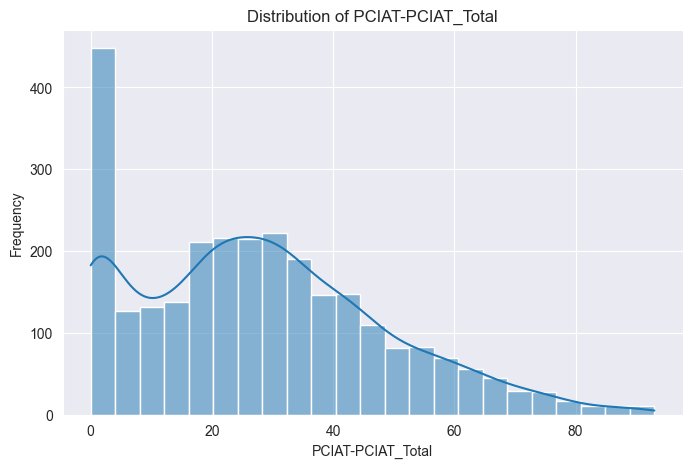

In [248]:
# Visualize the distribution of key numeric features
numeric_features = ['Basic_Demos-Age', 'Physical-Height', 'Physical-Weight', 'Physical-BMI', 'PCIAT-PCIAT_Total']

# Convert Polars DataFrame to pandas for plotting
train_pd = train.to_pandas()

# Replace any infinite values with NaN
train_pd = train_pd.replace([np.inf, -np.inf], np.nan)


# Visualize the distribution of key numeric features
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(train_pd[feature], kde=True)  # Drop NaN values for cleaner plots
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

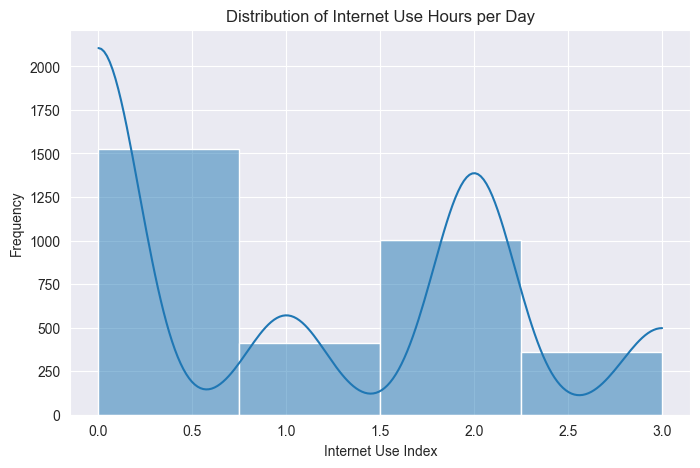

In [249]:
# Plot histogram for internet use hours distribution
plt.figure(figsize=(8, 5))
sns.histplot(train['PreInt_EduHx-computerinternet_hoursday'], kde=True, bins=4)
plt.title('Distribution of Internet Use Hours per Day')
plt.xlabel('Internet Use Index')
plt.ylabel('Frequency')
plt.show()

# Age-Related Effects: 

Different age groups might exhibit different levels of susceptibility to problematic internet use. Create a feature "age_PCIAT_interaction" which shows the relationship between age and a higher PCIAT score

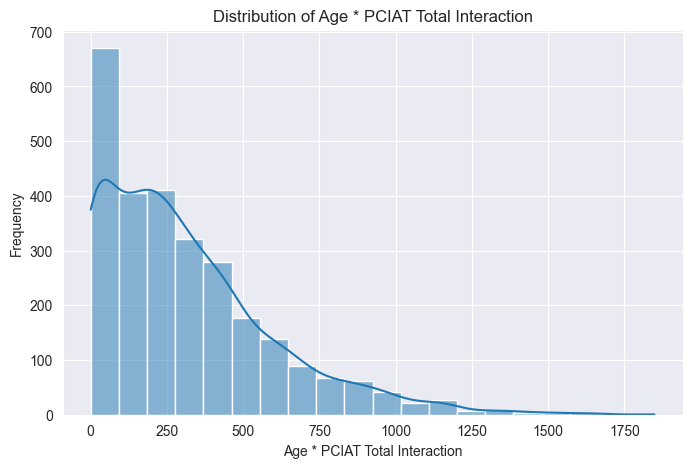

In [250]:
# Create interaction features, e.g., Age*PCIAT_Total to explore joint effects
train = train.with_columns(
    (pl.col('Basic_Demos-Age') * pl.col('PCIAT-PCIAT_Total')).alias('age_PCIAT_interaction')
)

# Convert the Polars DataFrame to pandas for plotting
train_pd = train.to_pandas()

plt.figure(figsize=(8, 5))
sns.histplot(train_pd['age_PCIAT_interaction'].dropna(), kde=True, bins=20)
plt.title('Distribution of Age * PCIAT Total Interaction')
plt.xlabel('Age * PCIAT Total Interaction')
plt.ylabel('Frequency')
plt.show()

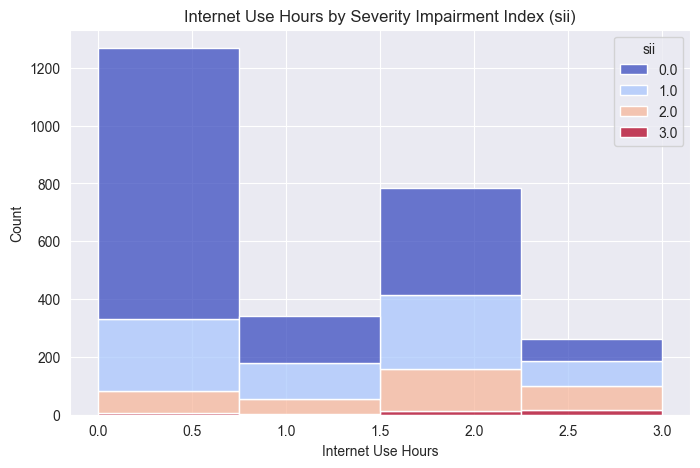

In [251]:
# Plot histogram for internet use hours by SII categories
plt.figure(figsize=(8, 5))
sns.histplot(data=train, x='PreInt_EduHx-computerinternet_hoursday', hue='sii', bins=4, multiple="stack", palette="coolwarm")
plt.title('Internet Use Hours by Severity Impairment Index (sii)')
plt.xlabel('Internet Use Hours')
plt.ylabel('Count')
plt.show()

Due to the high number of target variables, the heatmap is dense. We focus on the correlations between 'PCIAT-PCIAT_Total' and 'sii'.

# Handling Missing Data

Given the presence of missing values, we need to decide how to handle them.

* Numeric Features: We'll fill missing values with the mean of each feature.
* Categorical Features: We'll fill missing values with a special category 'NAN'.

# Data Preprocessing

## Concatenating Train and Test Data

In [252]:
with pl.StringCache():
    train_test = pl.concat([train, test], how="diagonal")
    train_test = train_test.with_columns(cs.string().cast(pl.Categorical).fill_null("NAN"))

# Split back into train and test
train = train_test[: train.height]
test = train_test[train.height:]

## Missing Data Imputation using KNNImputer

In this section, we handle the missing values in our training and test data using the **K-Nearest Neighbors Imputer (KNNImputer)** from `sklearn`. Missing values can negatively impact machine learning models, and it's important to handle them before training and testing the model. The KNN imputation method works by looking at the nearest neighbors of a data point and imputing the missing value based on the non-missing values of its neighbors.

### Steps:

1. **Create an instance of the KNNImputer**:
   - We initialize the KNNImputer with `n_neighbors=5`, meaning it will consider the 5 nearest neighbors when imputing missing values.
   - This method is useful when missing values are scattered and can be reasonably inferred from similar rows.

   ```python
   imputer = KNNImputer(n_neighbors=5)

In [253]:
# Create an instance of the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Select the columns for imputation and apply the imputer
imputed_array = imputer.fit_transform(train[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Physical-BMI']].to_pandas())
imputed_test_array = imputer.transform(test[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Physical-BMI']].to_pandas())

# Convert the NumPy array back to a Polars DataFrame
imputed_train = pl.DataFrame(imputed_array, schema=['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Physical-BMI'])
imputed_test = pl.DataFrame(imputed_test_array, schema=['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Physical-BMI'])

# Replace the imputed columns back into the original Polars DataFrame using with_columns
train = train.with_columns(
    [
        pl.Series('PCIAT-PCIAT_Total', imputed_train['PCIAT-PCIAT_Total']),
        pl.Series('Basic_Demos-Age', imputed_train['Basic_Demos-Age']),
        pl.Series('Physical-BMI', imputed_train['Physical-BMI'])
    ]
)
test = test.with_columns(
    [
        pl.Series('PCIAT-PCIAT_Total', imputed_test['PCIAT-PCIAT_Total']),
        pl.Series('Basic_Demos-Age', imputed_test['Basic_Demos-Age']),
        pl.Series('Physical-BMI', imputed_test['Physical-BMI'])
    ]
)

## Dropping Rows with Missing Target Values

In [254]:
# Drop rows where target variables are missing
train_without_null = train.drop_nulls(subset=TARGET_COLS)

## Separating Features and Target Variables

In [255]:
# Select features and target variables
X = train_without_null.select(FEATURE_COLS)
X_test = test.select(FEATURE_COLS)
y = train_without_null.select(TARGET_COLS)

## Converting to Pandas DataFrames

In [256]:
# Convert to pandas for compatibility with scikit-learn and PyTorch
X = X.to_pandas()
X_test = X_test.to_pandas()
y = y.to_pandas()

## Handling Missing Values

In [257]:
# Identify numerical features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Fill missing numerical values with mean
X[num_features] = X[num_features].fillna(X[num_features].mean())
X_test[num_features] = X_test[num_features].fillna(X_test[num_features].mean())

## Encoding Categorical Features

In [258]:
# Identify categorical features
cat_features = [col for col in FEATURE_COLS if col not in num_features]

# Fill missing categorical values and encode
label_encoders = {}
for col in cat_features:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

    # Add 'NAN' category if not present
    if "NAN" not in X[col].cat.categories:
        X[col] = X[col].cat.add_categories("NAN")
    if "NAN" not in X_test[col].cat.categories:
        X_test[col] = X_test[col].cat.add_categories("NAN")

    X[col] = X[col].fillna("NAN")
    X_test[col] = X_test[col].fillna("NAN")

    # Label encoding
    le = LabelEncoder()
    le.fit(pd.concat([X[col], X_test[col]], axis=0).astype(str))
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

## Feature Scaling

In [259]:
# Standardize numerical features
scaler = StandardScaler()
scaler.fit(pd.concat([X[num_features], X_test[num_features]], axis=0))
X[num_features] = scaler.transform(X[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Converting to NumPy Arrays

In [260]:
# Convert to NumPy arrays
X_np = X.values
X_test_np = X_test.values
y_np = y.values

# Modeling

We will use a combination of a neural network and a LightGBM model to predict the target variable 'sii'. By combining both models, we aim to leverage the strengths of each and improve overall performance.

## Neural Network Model

### Defining the Dataset Class

In [261]:
class TabularDataset(torch.utils.data.Dataset):
    """
    Dataset for handling tabular data, separating categorical and numerical features.
    """

    def __init__(self, X_categorical, X_numerical, y=None):
        self.X_categorical = torch.tensor(X_categorical, dtype=torch.long)
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X_categorical)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X_categorical[idx], self.X_numerical[idx], self.y[idx]
        else:
            return self.X_categorical[idx], self.X_numerical[idx]

### Defining the Neural Network Architecture

In [262]:
class MultiTargetRegressionModel(nn.Module):
    """
    Neural network model for multi-target regression using embeddings for categorical features
    and fully connected layers for regression.
    """

    def __init__(self, embedding_sizes, num_numerical_features, output_size):
        super(MultiTargetRegressionModel, self).__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(num_embeddings=categories, embedding_dim=size) for categories, size in embedding_sizes]
        )
        self.embedding_output_size = sum([size for _, size in embedding_sizes])
        self.fc1 = nn.Linear(self.embedding_output_size + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x_categorical, x_numerical):
        x = [emb(x_categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_numerical], 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.output(x)
        return x


## Model Explanation:

* Embeddings for Categorical Features: We use embedding layers to represent categorical features in a dense vector space.
* Fully Connected Layers: After combining embeddings with numerical features, we pass them through fully connected layers.
* Output Layer: # Prepare embeddings
embedding_sizes = []
for col in cat_features:
    num_categories = len(label_encoders[col].classes_)
    embedding_size = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, embedding_size))

num_numerical_features = len(num_features)
output_size = len(TARGET_COLS)
The model outputs predictions for all target variables.

## Preparing the Data for the Neural Network

In [263]:
# Prepare embeddings
embedding_sizes = []
for col in cat_features:
    num_categories = len(label_encoders[col].classes_)
    embedding_size = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, embedding_size))

num_numerical_features = len(num_features)
output_size = len(TARGET_COLS)

## Splitting the Data for Cross-Validation

In [264]:
# Define target variables for stratification
y_sii = y["sii"].to_numpy()
y_total = y["PCIAT-PCIAT_Total"].to_numpy()

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models = []
y_pred = np.full((X.shape[0], len(TARGET_COLS)), fill_value=np.nan)

## Training the Neural Network

In [265]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_sii)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Prepare data
    X_train_categorical = X_train[cat_features].values.astype(np.int64)
    X_val_categorical = X_val[cat_features].values.astype(np.int64)
    X_train_numerical = X_train[num_features].values.astype(np.float32)
    X_val_numerical = X_val[num_features].values.astype(np.float32)

    y_train_values = y_train.values.astype(np.float32)
    y_val_values = y_val.values.astype(np.float32)

    train_dataset = TabularDataset(X_train_categorical, X_train_numerical, y_train_values)
    val_dataset = TabularDataset(X_val_categorical, X_val_numerical, y_val_values)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Initialize model
    model = MultiTargetRegressionModel(embedding_sizes, num_numerical_features, output_size)
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 1 if IS_TEST else 100
    best_val_loss = np.inf
    patience = 10
    counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_cat_batch, X_num_batch, y_batch in train_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_cat_batch, X_num_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_cat_batch, X_num_batch, y_batch in val_loader:
                X_cat_batch = X_cat_batch.to(device)
                X_num_batch = X_num_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_cat_batch, X_num_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    if best_model_state is None:
        print("No valid model was trained in this fold due to NaNs.")
        continue

    model.load_state_dict(best_model_state)
    models.append(model)

    # Predictions on validation set
    model.eval()
    val_preds = []
    with torch.no_grad():
        for X_cat_batch, X_num_batch, y_batch in val_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            outputs = model(X_cat_batch, X_num_batch)
            val_preds.append(outputs.cpu().numpy())
    val_preds = np.vstack(val_preds)

    y_pred[val_idx] = val_preds

Fold 1
Epoch 1/100, Train Loss: 56.8467, Val Loss: 50.9991
Epoch 2/100, Train Loss: 52.6273, Val Loss: 46.7887
Epoch 3/100, Train Loss: 47.9128, Val Loss: 40.5263
Epoch 4/100, Train Loss: 40.0651, Val Loss: 32.7724
Epoch 5/100, Train Loss: 30.3338, Val Loss: 23.8609
Epoch 6/100, Train Loss: 21.7664, Val Loss: 17.9820
Epoch 7/100, Train Loss: 17.7522, Val Loss: 17.2956
Epoch 8/100, Train Loss: 17.1267, Val Loss: 16.5023
Epoch 9/100, Train Loss: 16.7004, Val Loss: 15.9914
Epoch 10/100, Train Loss: 16.1731, Val Loss: 15.8177
Epoch 11/100, Train Loss: 16.0900, Val Loss: 15.7906
Epoch 12/100, Train Loss: 15.6820, Val Loss: 15.7381
Epoch 13/100, Train Loss: 15.4951, Val Loss: 15.5854
Epoch 14/100, Train Loss: 15.3940, Val Loss: 15.4805
Epoch 15/100, Train Loss: 15.6289, Val Loss: 15.4323
Epoch 16/100, Train Loss: 15.1451, Val Loss: 15.4180
Epoch 17/100, Train Loss: 14.8431, Val Loss: 15.3742
Epoch 18/100, Train Loss: 14.5445, Val Loss: 15.3240
Epoch 19/100, Train Loss: 14.9480, Val Loss: 15.

## Training Process Explanation:

* We perform 5-fold cross-validation to evaluate the model's performance.
* Early stopping is used to prevent overfitting.
* The model predicts all target variables simultaneously.

## LightGBM Model

We also train a LightGBM model to predict 'PCIAT-PCIAT_Total'.

### Defining LightGBM Parameters

In [266]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': SEED,
}

## Training the LightGBM Model

In [267]:
categorical_feature_indices = [X.columns.get_loc(col) for col in cat_features]

models_lgb = []
y_pred_lgb = np.full((X.shape[0],), fill_value=np.nan)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_sii)):
    print(f"LightGBM Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_total[train_idx], y_total[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feature_indices)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_feature_indices)

    model = lgb.train(
        params=lgb_params,
        train_set=train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)],
    )
    models_lgb.append(model)
    y_pred_lgb[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)

LightGBM Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 11.9421	valid_1's rmse: 17.712
LightGBM Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 13.1839	valid_1's rmse: 16.8152
LightGBM Fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's rmse: 13.0356	valid_1's rmse: 17.071
LightGBM Fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's rmse: 13.308	valid_1's rmse: 17.066
LightGBM Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's rmse: 14.0809	valid_1's rmse: 17.5608


## Training Process Explanation:

* We perform 5-fold cross-validation.
* Early stopping is used based on validation loss.
* Categorical features are specified for LightGBM to handle them internally.

## Model Evaluation and Optimization

### Combining Neural Network and LightGBM Predictions

We aim to combine the predictions from both models to improve performance.

### Defining an Optimizer for Thresholds

Use Optuna to put the predicted test scores into the 4 categories by maximizing the Quadratic Weighted Kappa score

In [268]:
class OptimizedRounder:
    """
    Optimizes rounding of continuous predictions into discrete class labels by maximizing
    the Quadratic Weighted Kappa (QWK) score using Optuna optimization.
    """

    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: np.ndarray, y_true: np.ndarray) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = thresholds[-1] if i > 0 else y_pred.min()
                high = y_pred.max()
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")

        with np.errstate(invalid='ignore'):
            study.optimize(objective, n_trials=self.n_trials)

        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: np.ndarray) -> np.ndarray:
        assert hasattr(self, "thresholds"), "You must call fit() before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: np.ndarray) -> np.ndarray:
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

## Optimizing the Weights for Combining Models

It tries to see if the models agree on which sii rating to give, and if not it comes up with a weighted plan for handling disagreements.

In [269]:
def optimize_weights(y_true, y_pred_nn, y_pred_lgb):
    def objective(trial):
        w_nn = trial.suggest_float('w_nn', 0.0, 1.0)
        y_pred_combined = w_nn * y_pred_nn + (1 - w_nn) * y_pred_lgb
        optimizer_rounder = OptimizedRounder(n_classes=4, n_trials=100)
        optimizer_rounder.fit(y_pred_combined, y_true)
        y_pred_rounded = optimizer_rounder.predict(y_pred_combined)
        qwk = cohen_kappa_score(y_true, y_pred_rounded, weights="quadratic")
        return qwk

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    best_weight = study.best_params['w_nn']
    best_qwk = study.best_value
    print(f"Best weight: {best_weight}, Best QWK: {best_qwk}")
    return best_weight

# Combine predictions
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
best_weight = optimize_weights(y_sii, y_pred_total, y_pred_lgb)
print(f"Optimized weight for neural network: {best_weight}")

Best weight: 0.3659844765083899, Best QWK: 0.4625252648020224
Optimized weight for neural network: 0.3659844765083899


## Model Evaluation

In [270]:
# Calculate QWK score for the neural network model predictions
optimizer_rounder_nn = OptimizedRounder(n_classes=4, n_trials=100)
optimizer_rounder_nn.fit(y_pred_total, y_sii)
y_pred_nn_rounded = optimizer_rounder_nn.predict(y_pred_total)
qwk_nn = cohen_kappa_score(y_sii, y_pred_nn_rounded, weights="quadratic")
print(f"Neural Network QWK Score: {qwk_nn}")

# Calculate QWK score for the LightGBM model predictions
optimizer_rounder_lgb = OptimizedRounder(n_classes=4, n_trials=100)
optimizer_rounder_lgb.fit(y_pred_lgb, y_sii)
y_pred_lgb_rounded = optimizer_rounder_lgb.predict(y_pred_lgb)
qwk_lgb = cohen_kappa_score(y_sii, y_pred_lgb_rounded, weights="quadratic")
print(f"LightGBM QWK Score: {qwk_lgb}")

Neural Network QWK Score: 0.4315965436908896
LightGBM QWK Score: 0.4421294845317907


We can see that the two models have similar accuracy. We will combine them to create an ensemble model, weighting their votes based on how accurate they were.

## Evaluating the Combined Model

In [271]:
y_pred_combined_total = best_weight * y_pred_total + (1 - best_weight) * y_pred_lgb

optimizer_rounder = OptimizedRounder(n_classes=4, n_trials=300)
optimizer_rounder.fit(y_pred_combined_total, y_sii)
y_pred_combined_rounded = optimizer_rounder.predict(y_pred_combined_total)

qwk_combined = cohen_kappa_score(y_sii, y_pred_combined_rounded, weights="quadratic")
print(f"Optimized Combined Models QWK Score: {qwk_combined}")

Optimized Combined Models QWK Score: 0.46406066551687863


Results:

* The optimized weight for combining models is determined.
* The combined model achieves a Quadratic Weighted Kappa (QWK) score of approximately ~0.46

# Making Predictions on the Test Set

In [272]:
# Prepare test data for neural network
X_test_categorical = X_test[cat_features].values.astype(np.int64)
X_test_numerical = X_test[num_features].values.astype(np.float32)

# Ensure no NaNs in test data
assert not np.isnan(X_test_numerical).any(), "NaNs found in X_test_numerical"
assert not np.isnan(X_test_categorical).any(), "NaNs found in X_test_categorical"

test_dataset = TabularDataset(X_test_categorical, X_test_numerical)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

# Neural network predictions
test_preds_list = []
for model in models:
    model.eval()
    test_preds = []
    with torch.no_grad():
        for X_cat_batch, X_num_batch in test_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            outputs = model(X_cat_batch, X_num_batch)
            test_preds.append(outputs.cpu().numpy())
    test_preds = np.vstack(test_preds)
    test_preds_list.append(test_preds)

test_preds_mean = np.mean(test_preds_list, axis=0)
test_pred_total = test_preds_mean[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]

# LightGBM test predictions
test_preds_lgb_list = []
for model in models_lgb:
    test_preds_lgb = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds_lgb_list.append(test_preds_lgb)

test_preds_lgb_mean = np.mean(test_preds_lgb_list, axis=0)

# Combine test predictions
test_pred_combined_total = (best_weight * test_pred_total + (1 - best_weight) * test_preds_lgb_mean)
test_pred_combined_rounded = optimizer_rounder.predict(test_pred_combined_total)

# Submission

In [273]:
# Prepare submission file
submission = test.select("id").to_pandas()
submission["sii"] = test_pred_combined_rounded
submission.to_csv("submission.csv", index=False)

# Conclusions

* We successfully developed a predictive model combining a neural network and a LightGBM model.
* The optimized combined model achieved a QWK score of approximately ~0.46 on the validation set.
* The use of embedding layers for categorical features and combining models helped improve performance.
* Future work could include hyperparameter tuning, feature engineering, and exploring alternative models to further improve results.